# 1. Importing libraries

In [32]:
import time
import numpy as np 
import pandas as pd 
from tqdm.auto import tqdm
from kneed import KneeLocator
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from category_encoders import TargetEncoder
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings


plt.rcdefaults()
plt.rcParams['figure.figsize'] = [12, 12]
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

# 2. Importing data

In [33]:
cols = pd.read_csv('data/census-bureau.columns', header=None)[0].str.replace(' ', '_', regex=True).tolist()
cols = cols[:-1]+['salary']
df = pd.read_csv('data/census-bureau.data',names=cols)
df.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,salary
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [34]:
og_data = df.copy()

# 3. Data Preprocessing

In [35]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))

## 3.1. Missing Value Imputation

In [36]:
df.hispanic_origin.fillna('Do not know',inplace=True)

## 3.2. Encoding Categorical Variables

In [37]:
def education_encoder(x):
    if x == 'Children':
        return 1
    elif x == 'Less than 1st grade':
        return 2
    elif x == '1st 2nd 3rd or 4th grade':
        return 3
    elif x == '5th or 6th grade':
        return 4
    elif x == '7th and 8th grade':
        return 5
    elif x == '9th grade':
        return 6
    elif x == '10th grade':
        return 7
    elif x == '11th grade':
        return 8
    elif x == '12th grade no diploma':
        return 9
    elif x == 'High school graduate':
        return 10
    elif x == 'Some college but no degree':
        return 11
    elif x == 'Associates degree-occup /vocational':
        return 12
    elif x == 'Associates degree-academic program':
        return 13
    elif x == 'Bachelors degree(BA AB BS)':
        return 14
    elif x == 'Masters degree(MA MS MEng MEd MSW MBA)':
        return 15
    elif x == 'Doctorate degree(PhD EdD)':
        return 16
    elif x == 'Prof school degree (MD DDS DVM LLB JD)':
        return 17
    
def salary_encoder(x):
    if x == '- 50000.':
        return 1
    elif x == '50000+.':
        return 2

Implementing ordinal encoding to education and salary since they have an inherent order to them however the flaw might be that we do not know how big the gap between the orders are

In [38]:
df['education'] = df['education'].apply(education_encoder)
df['salary'] = df['salary'].apply(salary_encoder)

In [39]:
cat_cols2 = [c for c in cat_cols if c not in ['education','salary']]
num_cols2 = df._get_numeric_data().columns

One hot encoding the rest of the data since we want to calculate distances

In [40]:
enc = OneHotEncoder(handle_unknown='ignore')
tmp_cat_enc = enc.fit_transform(df[cat_cols2]).toarray()
tmp_cat_df = pd.DataFrame(tmp_cat_enc, columns=enc.get_feature_names_out())

## 3.2. Standardization for numerical cols

In [41]:
scaler = StandardScaler()
df[num_cols2] = scaler.fit_transform(df[num_cols2])

## 3.3 Combining all processed data

In [42]:
x = pd.concat([df[num_cols2], tmp_cat_df], axis=1)

In [43]:
x.head()

,age,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,weight,num_persons_worked_for_employer,...,major_industry_code_Wholesale trade,member_of_a_labor_union_No,member_of_a_labor_union_Not in universe,member_of_a_labor_union_Yes,tax_filer_stat_Head of household,tax_filer_stat_Joint both 65+,tax_filer_stat_Joint both under 65,tax_filer_stat_Joint one under 65 & one 65+,tax_filer_stat_Nonfiler,tax_filer_stat_Single
0,1.725879,-0.849740,-0.782235,0.408476,-0.201629,-0.092542,-0.137236,-0.099553,-0.040543,-0.827096,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.053560,-0.628343,1.570028,0.620062,-0.201629,-0.092542,-0.137236,-0.099553,-0.691139,-0.404284,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.739291,-0.849740,-0.782235,-0.226279,-0.201629,-0.092542,-0.137236,-0.099553,-0.753126,-0.827096,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.142682,-0.849740,-0.782235,-1.495789,-0.201629,-0.092542,-0.137236,-0.099553,0.017871,-0.827096,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.097861,-0.849740,-0.782235,-1.495789,-0.201629,-0.092542,-0.137236,-0.099553,-0.675431,-0.827096,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# 4. Clustering

## 4.1 Elbow Method

In [22]:
cluster_size = [2,4,6,8,10,15,20,30,40,50,75,100,150,200]

clusters = []
sum_of_squared_distances = []
for k in tqdm(cluster_size):
    kmeans = KMeans(n_clusters=k, random_state=int(time.time()))
    kmeans.fit(x)
    clusters.append(kmeans.labels_)

    sum_of_squared_distances.append(kmeans.inertia_)
    

100%|██████████| 14/14 [22:32<00:00, 96.60s/it] 


In [30]:
kn = KneeLocator(cluster_size, sum_of_squared_distances, curve='convex', direction='decreasing')
print('Optimal number of clusters: ', kn.elbow)

Optimal number of clusters:  30


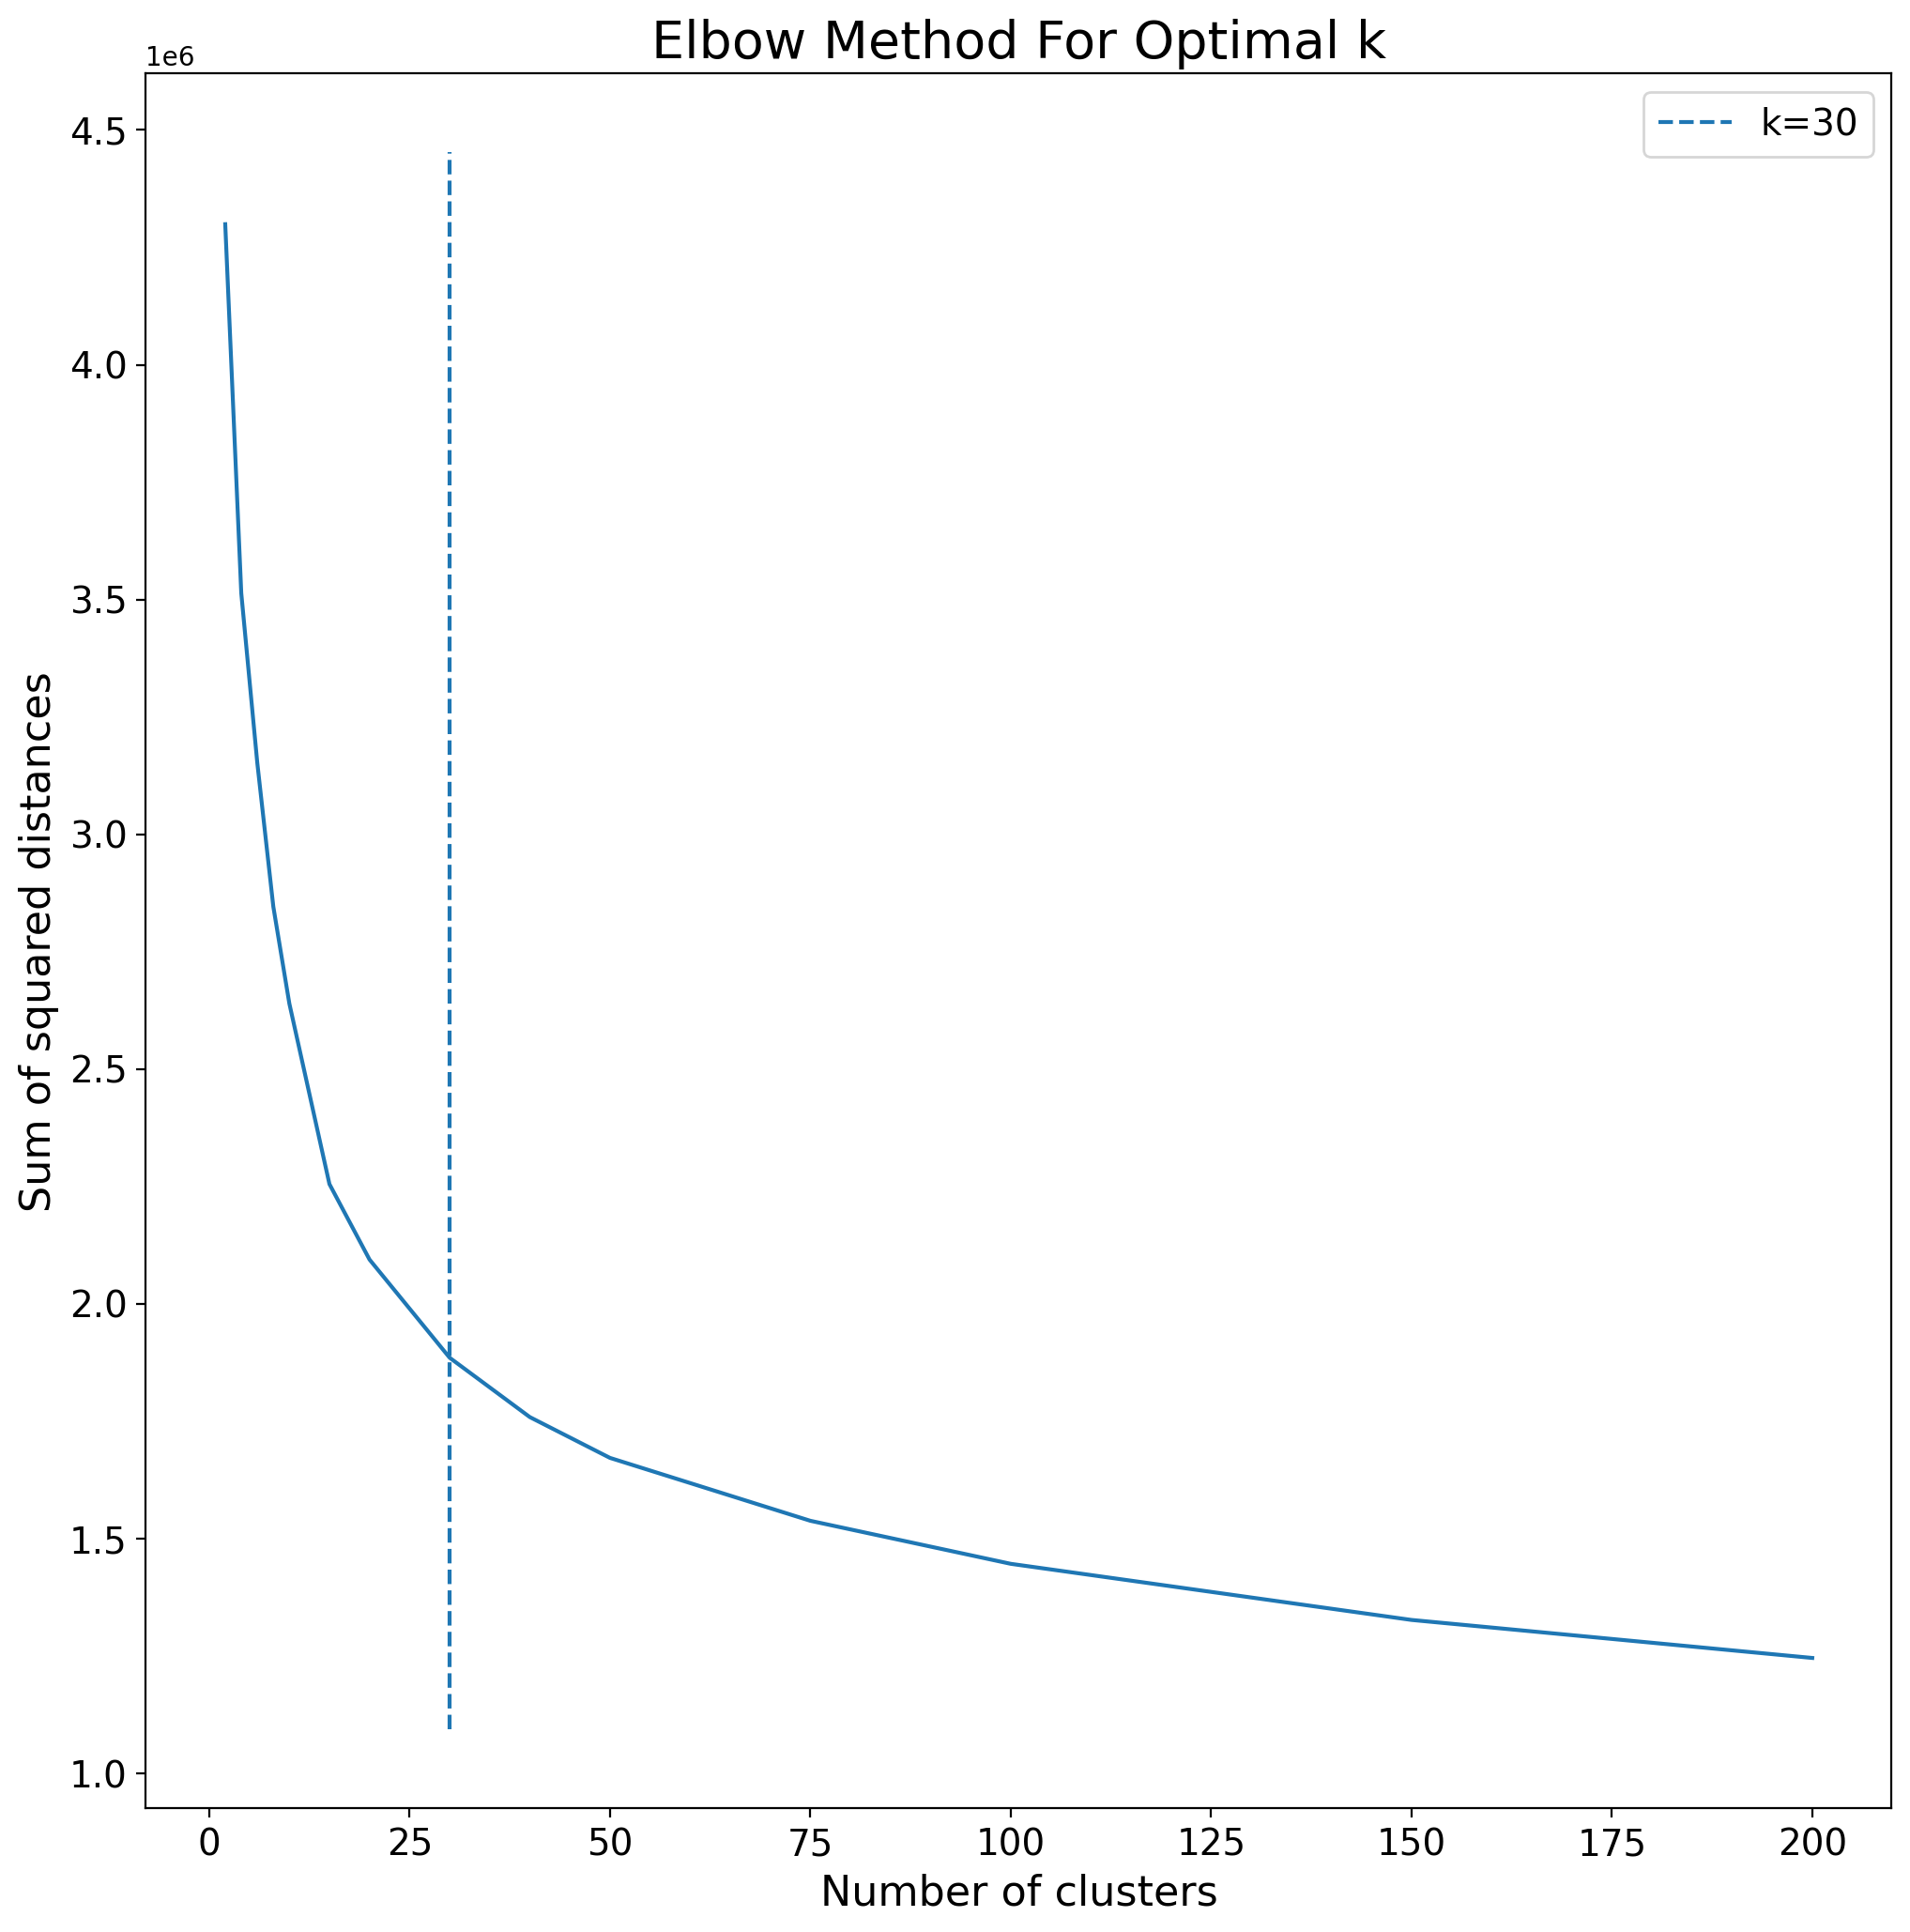

In [108]:
plt.plot(cluster_size, sum_of_squared_distances)
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',label='k=30')
plt.xlabel('Number of clusters',fontsize=16)
plt.ylabel('Sum of squared distances',fontsize=16)
plt.title('Elbow Method For Optimal k',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()


Using the elbow plot we determine the optimal number of clusters to be 30. 

## 4.2 Silhouette Method

In [ ]:
# silhouette_avg = []
# for c in tqdm(clusters):
#     silhouette_avg.append(silhouette_score(x, c))


Silhouette method not run due to runtime being too long

## 4.3 Optimal K-Means Clustering

In [44]:
kmeans = KMeans(n_clusters=30, random_state=int(time.time()))
kmeans.fit(x)
og_data['cluster'] = kmeans.labels_

In [45]:
og_data.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,salary,cluster
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,23
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,7
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.,26
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,12
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,12


# 5. Analysis

## 5.1 Cluster Distribution

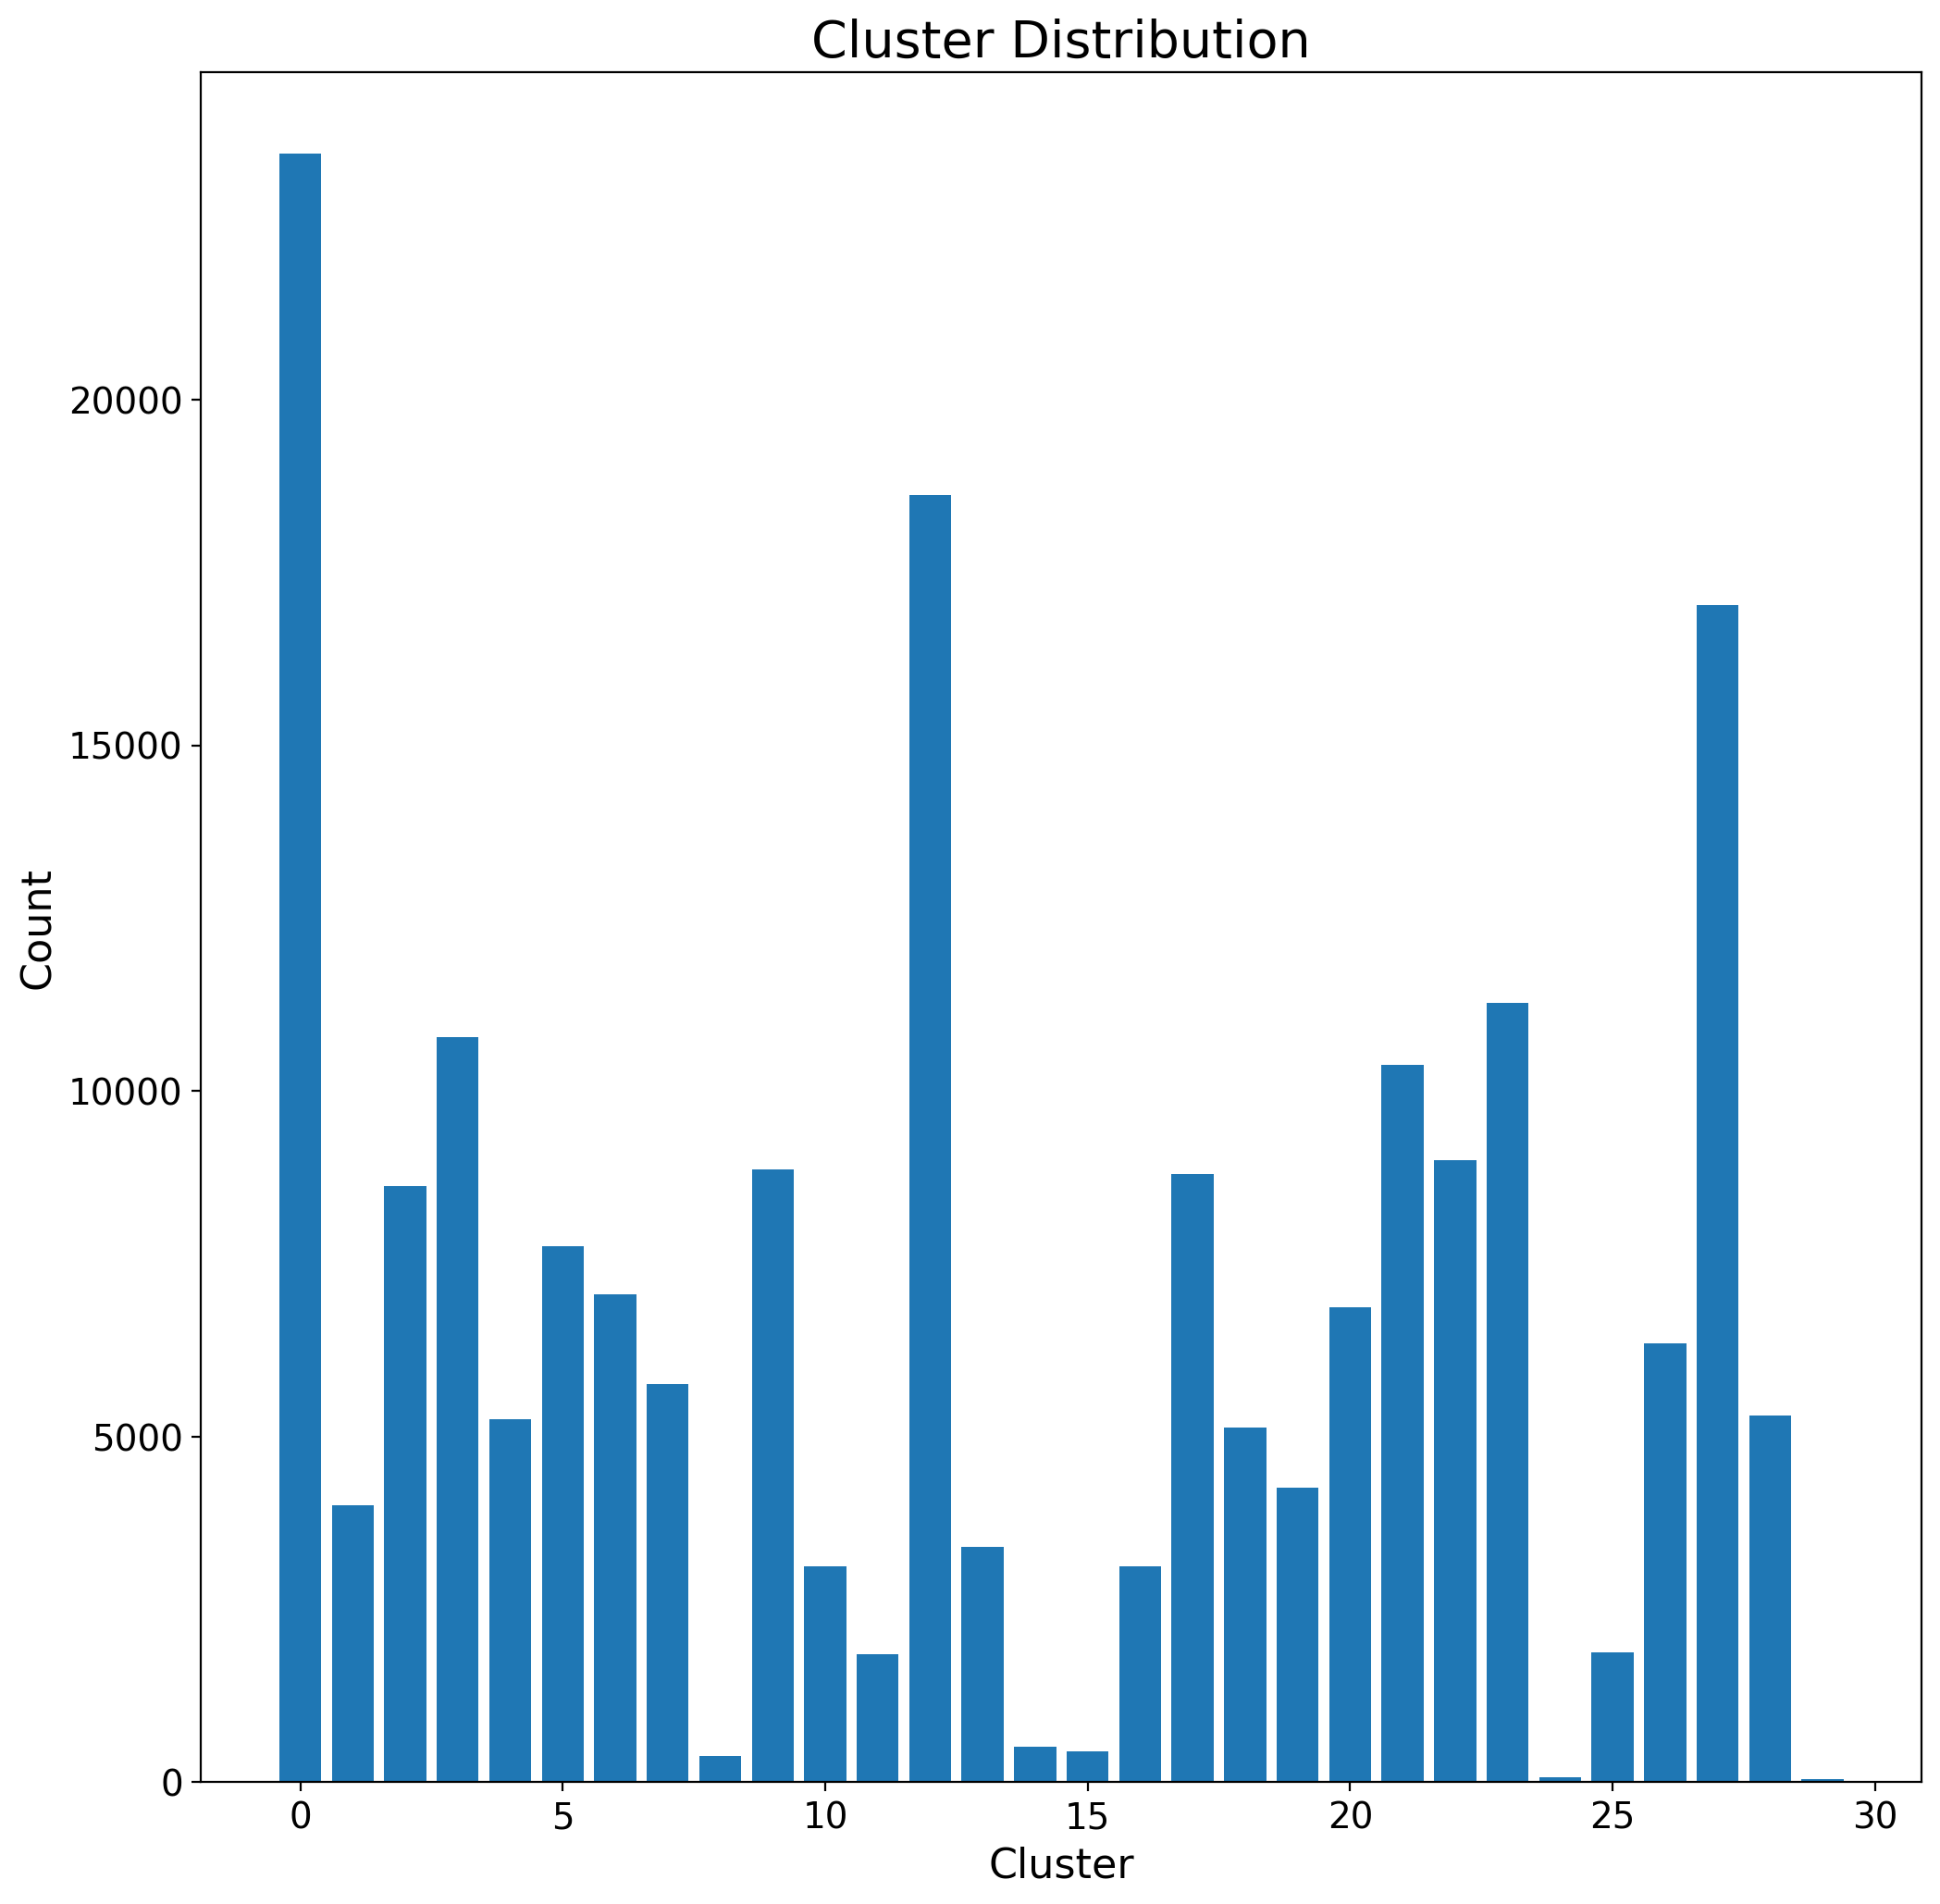

In [109]:
plt.bar(og_data['cluster'].value_counts().index, og_data['cluster'].value_counts())
plt.xlabel('Cluster',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.title('Cluster Distribution',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## 5.2 Cluster Profiles

Creating interpretable cluster profiles that can be used for marketting

In [56]:
cluster_data = []
for i in range(30):
    cluster_data.append(og_data[og_data.cluster==i])

In [84]:
cluster_profiles = {}

for i in range(len(cluster_data)):
    cd = cluster_data[i]

    profiles = {'cluster_size': len(cd),
                'demographics': {},
                'monetary': {},
                'work': {}}

    # demographics
    avg_age = cd.age.mean()
    age_range = str(cd.age.min()) + '-' + str(cd.age.max())

    majority_sex = cd.sex.value_counts().idxmax()
    sex_percentage = cd.sex.value_counts()[majority_sex]/len(cd)

    majority_race = cd.race.value_counts().idxmax()
    race_percentage = cd.race.value_counts()[majority_race]/len(cd)

    majority_hispanic_origin = cd.hispanic_origin.value_counts().idxmax()
    hispanic_origin_percentage = cd.hispanic_origin.value_counts()[majority_hispanic_origin]/len(cd)

    majority_education = cd.education.value_counts().idxmax()
    education_percentage = cd.education.value_counts()[majority_education]/len(cd)

    majority_country_of_birth_self = cd.country_of_birth_self.value_counts().idxmax()
    country_of_birth_self_percentage = cd.country_of_birth_self.value_counts()[majority_country_of_birth_self]/len(cd)

    majority_citizenship = cd.citizenship.value_counts().idxmax()
    citizenship_percentage = cd.citizenship.value_counts()[majority_citizenship]/len(cd)

    profiles['demographics'] = {
                                'age': {'avg': avg_age, 'range': age_range},
                                'sex': {'majority': majority_sex, 'percentage': sex_percentage},
                                'race': {'majority': majority_race, 'percentage': race_percentage},
                                'hispanic_origin': {'majority': majority_hispanic_origin, 'percentage': hispanic_origin_percentage},
                                'education': {'majority': majority_education, 'percentage': education_percentage},
                                'country_of_birth_self': {'majority': majority_country_of_birth_self, 'percentage': country_of_birth_self_percentage},
                                'citizenship': {'majority': majority_citizenship, 'percentage': citizenship_percentage}
                            }
    
    # monetary
    majority_salary = cd.salary.value_counts().idxmax()
    salary_percentage = cd.salary.value_counts()[majority_salary]/len(cd)

    avg_wage_per_hour = cd.wage_per_hour.mean()
    wage_per_hour_range = str(cd.wage_per_hour.min()) + '-' + str(cd.wage_per_hour.max())

    avg_capital_gains = cd.capital_gains.mean()
    capital_gains_range = str(cd.capital_gains.min()) + '-' + str(cd.capital_gains.max())

    avg_capital_losses = cd.capital_losses.mean()
    capital_losses_range = str(cd.capital_losses.min()) + '-' + str(cd.capital_losses.max())
    
    avg_dividends_from_stocks = cd.dividends_from_stocks.mean()
    dividends_from_stocks_range = str(cd.dividends_from_stocks.min()) + '-' + str(cd.dividends_from_stocks.max())

    majority_tax_filer_stat = cd.tax_filer_stat.value_counts().idxmax()
    tax_filer_stat_percentage = cd.tax_filer_stat.value_counts()[majority_tax_filer_stat]/len(cd)
    
    profiles['monetary'] = {
        'salary': {'majority': majority_salary, 'percentage': salary_percentage},
        'wage_per_hour': {'avg': avg_wage_per_hour, 'range': wage_per_hour_range},
        'capital_gains': {'avg': avg_capital_gains, 'range': capital_gains_range},
        'capital_losses': {'avg': avg_capital_losses, 'range': capital_losses_range},
        'dividends_from_stocks': {'avg': avg_dividends_from_stocks, 'range': dividends_from_stocks_range},
        'tax_filer_stat': {'majority': majority_tax_filer_stat, 'percentage': tax_filer_stat_percentage}
    }
    
    
    # work related
    majority_class_of_worker = cd.class_of_worker.value_counts().idxmax()
    class_of_worker_percentage = cd.class_of_worker.value_counts()[majority_class_of_worker]/len(cd)

    majority_detailed_industry_recode = cd.detailed_industry_recode.value_counts().idxmax()
    detailed_industry_recode_percentage = cd.detailed_industry_recode.value_counts()[majority_detailed_industry_recode]/len(cd)

    majority_detailed_occupation_recode = cd.detailed_occupation_recode.value_counts().idxmax()
    detailed_occupation_recode_percentage = cd.detailed_occupation_recode.value_counts()[majority_detailed_occupation_recode]/len(cd)

    majority_major_industry_code = cd.major_industry_code.value_counts().idxmax()
    major_industry_code_percentage = cd.major_industry_code.value_counts()[majority_major_industry_code]/len(cd)

    majority_major_occupation_code = cd.major_occupation_code.value_counts().idxmax()
    major_occupation_code_percentage = cd.major_occupation_code.value_counts()[majority_major_occupation_code]/len(cd)

    majority_member_of_a_labor_union = cd.member_of_a_labor_union.value_counts().idxmax()
    member_of_a_labor_union_percentage = cd.member_of_a_labor_union.value_counts()[majority_member_of_a_labor_union]/len(cd)

    majority_reason_for_unemployment = cd.reason_for_unemployment.value_counts().idxmax()
    reason_for_unemployment_percentage = cd.reason_for_unemployment.value_counts()[majority_reason_for_unemployment]/len(cd)
    
    majority_full_or_part_time_employment_stat = cd.full_or_part_time_employment_stat.value_counts().idxmax()
    full_or_part_time_employment_stat_percentage = cd.full_or_part_time_employment_stat.value_counts()[majority_full_or_part_time_employment_stat]/len(cd)
    
    majority_own_business_or_self_employed = cd.own_business_or_self_employed.value_counts().idxmax()
    own_business_or_self_employed_percentage = cd.own_business_or_self_employed.value_counts()[majority_own_business_or_self_employed]/len(cd)

    majority_weeks_worked_in_year = cd.weeks_worked_in_year.value_counts().idxmax()
    weeks_worked_in_year_percentage = cd.weeks_worked_in_year.value_counts()[majority_weeks_worked_in_year]/len(cd)
    
    avg_weeks_worked_in_year = cd.weeks_worked_in_year.mean()
    weeks_worked_in_year_range = str(cd.weeks_worked_in_year.min()) + '-' + str(cd.weeks_worked_in_year.max())

    profiles['work'] = {
        'class_of_worker': {'majority': majority_class_of_worker, 'percentage': class_of_worker_percentage},
        'detailed_industry_recode': {'majority': majority_detailed_industry_recode, 'percentage': detailed_industry_recode_percentage},
        'detailed_occupation_recode': {'majority': majority_detailed_occupation_recode, 'percentage': detailed_occupation_recode_percentage},
        'major_industry_code': {'majority': majority_major_industry_code, 'percentage': major_industry_code_percentage},
        'major_occupation_code': {'majority': majority_major_occupation_code, 'percentage': major_occupation_code_percentage},
        'member_of_a_labor_union': {'majority': majority_member_of_a_labor_union, 'percentage': member_of_a_labor_union_percentage},
        'reason_for_unemployment': {'majority': majority_reason_for_unemployment, 'percentage': reason_for_unemployment_percentage},
        'full_or_part_time_employment_stat': {'majority': majority_full_or_part_time_employment_stat, 'percentage': full_or_part_time_employment_stat_percentage},
        'own_business_or_self_employed': {'majority': majority_own_business_or_self_employed, 'percentage': own_business_or_self_employed_percentage},
        'weeks_worked_in_year': {'avg': avg_weeks_worked_in_year, 'range': weeks_worked_in_year_range}
    }
    
    cluster_profiles[i] = profiles
    

## 5.3 Filtering Profiles that do not provide any information

In [86]:
dic_remove = {}
for i in range(30):
    remove_sub_keys = []
    profile = cluster_profiles[i]
    for key in profile.keys():
        if key == 'cluster_size':
            continue
        for sub_key in profile[key].keys():
            if 'percentage' in profile[key][sub_key].keys():
                if profile[key][sub_key]['percentage'] < 0.9:
                    remove_sub_keys.append(sub_key)
    dic_remove[i] = remove_sub_keys
                    

In [87]:
for i in range(30):
    for sub_key in dic_remove[i]:
        for key in cluster_profiles[i].keys():
            if key == 'cluster_size':
                continue
            if sub_key in cluster_profiles[i][key].keys():
                del cluster_profiles[i][key][sub_key]


In [98]:
all_profile_df_unnested = []
for j in range(30):
    tmp = pd.DataFrame(cluster_profiles[j]).reset_index()
    for i in range(len(tmp)):
        if pd.notna(tmp.demographics.iloc[i]):
            for k in tmp.demographics.iloc[i].keys():
                if 'demographics_'+k not in tmp.columns:
                    tmp['demographics_'+k] = np.nan
                tmp['demographics_'+k].iloc[i] = tmp.demographics.iloc[i][k]
        
        if pd.notna(tmp.monetary.iloc[i]):
            for k in tmp.monetary.iloc[i].keys():
                if 'monetary_'+k not in tmp.columns:
                    tmp['monetary_'+k] = np.nan
                tmp['monetary_'+k].iloc[i] = tmp.monetary.iloc[i][k]

        if pd.notna(tmp.work.iloc[i]):
            for k in tmp.work.iloc[i].keys():
                if 'work_'+k not in tmp.columns:
                    tmp['work_'+k] = np.nan
                tmp['work_'+k].iloc[i] = tmp.work.iloc[i][k]
        
    all_profile_df_unnested.append(tmp)

In [99]:
with pd.ExcelWriter('cluster_profiles.xlsx') as writer:
    for i in range(30):
        all_profile_df_unnested[i].to_excel(writer, sheet_name=f'Cluster {i}', index=False)